## 220518 NSPHL test genomes quast results

In [1]:
from pathlib import Path
import re

In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

## Setup

In [4]:
DATESTR = '220518'
NBNAME = f'{DATESTR}-nsphl-test-genomes-quast-results'

In [5]:
infiles = dict(
    quast_results='data-src/220518-nsphl-test-seq-quast-report.tsv',
)

In [6]:
processed_out = Path('data-processed') / NBNAME
processed_out.mkdir(exist_ok=True)

In [7]:
outfiles = dict(
    main=processed_out / f'{DATESTR}-nsphl-test-genomes-quast-results.csv',
    by_bp=processed_out / f'{DATESTR}-nsphl-test-genomes-quast-results-by-min-bp.csv',
)

## Code

In [8]:
def load_quast_results(file):
    df = pd.read_csv(file, sep='\t', index_col=0, dtype=object).transpose()
    df.columns.name = None
    df.index.name = 'file'
    
    for col, values in df.iteritems():
        df[col] = pd.to_numeric(values)
    
    return df


BP_RE = re.compile('\(>= (\d+) bp\)$')


def min_bp_cols(results):

    ncontigs_cols = [col for col in results.columns if col.startswith('# contigs (')]
    total_len_cols = [col for col in results.columns if col.startswith('Total length (')]

    min_bp = [int(BP_RE.search(col).group(1)) for col in ncontigs_cols]
    assert [int(BP_RE.search(col).group(1)) for col in total_len_cols] == min_bp
    
    return ncontigs_cols, total_len_cols, min_bp


def stack_min_bp(results):
    ncontigs_cols, total_len_cols, min_bp = min_bp_cols(results)
    
    df = results[ncontigs_cols + total_len_cols]
    df.columns = pd.MultiIndex.from_product([['ncontigs', 'total_len'], min_bp], names=[None, 'min_bp'])
    
    return df.stack('min_bp')


def split_results(results):
    stacked = stack_min_bp(results)
    results2 = results[[col for col in results.columns if BP_RE.search(col) is None]].copy()
    return stacked, results2

## Parse QUAST output

In [9]:
results = load_quast_results(infiles['quast_results'])

In [10]:
by_bp, results2 = split_results(results)
results2.columns.name = 'statistic'

In [11]:
results2['mean_contig_length'] = results2['Total length'] / results2['# contigs']

results2['Total length unfiltered'] = by_bp.xs(0, level='min_bp')['total_len']
results2['# contigs unfiltered'] = by_bp.xs(0, level='min_bp')['ncontigs']

results2['frac_contigs_filtered'] = 1 - results2['# contigs'] / results2['# contigs unfiltered']
results2['frac_length_filtered'] = 1 - results2['Total length'] / results2['Total length unfiltered']

## Plots

In [12]:
plot_cols = list(results2.columns)

df_skinny = results2.unstack().to_frame('value')

In [13]:
log_cols = ['# contigs', 'Largest contig', 'Total length', 'N50', 'N75', 'L50', 'L75', 'Total length unfiltered', '# contigs unfiltered']

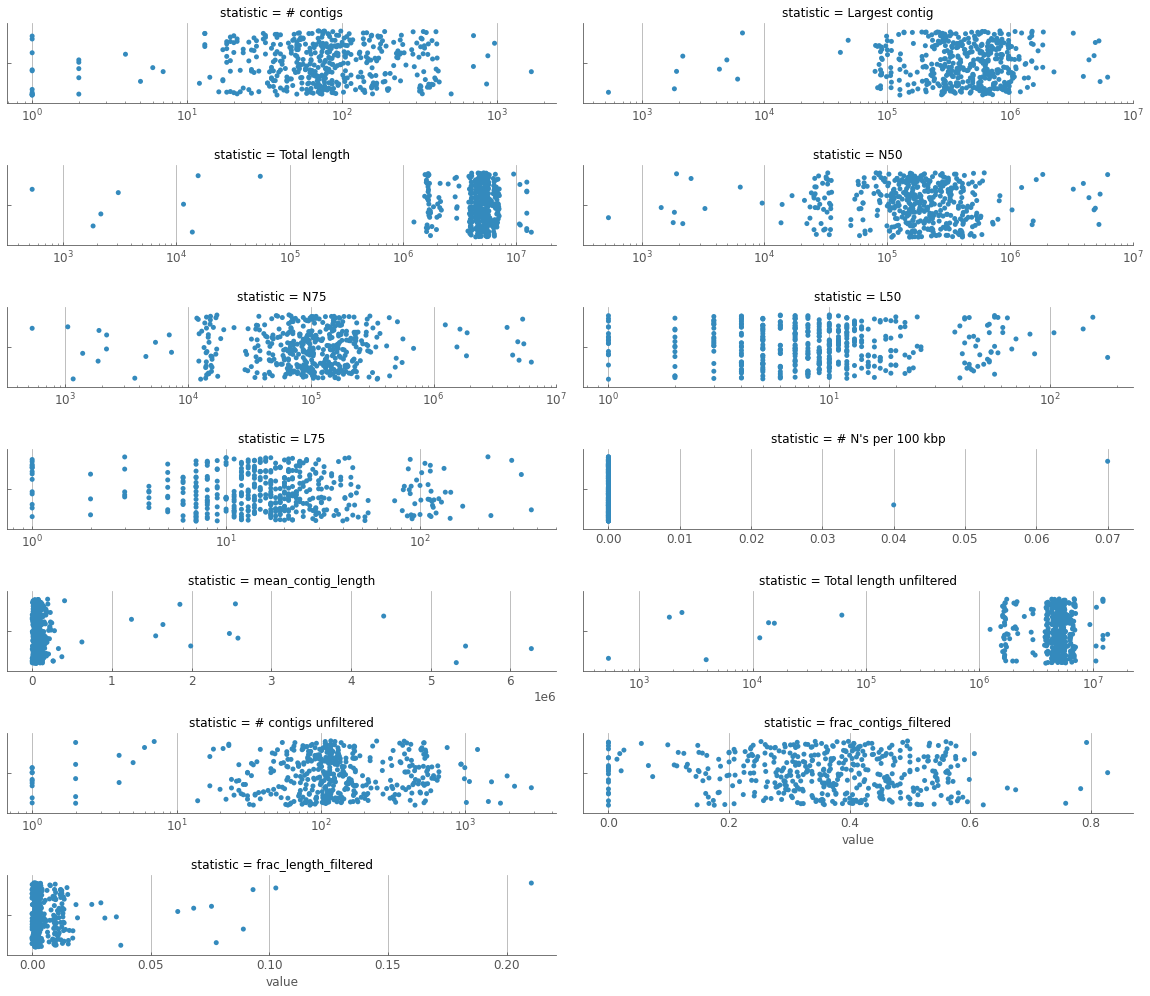

In [14]:
fg = sns.catplot(
    data=df_skinny.reset_index(),
    x='value',
    kind='strip',
    col='statistic',
    aspect=4,
    sharex=False,
    height=2,
    col_wrap=2,
    jitter=.4,
)

for col, ax in fg.axes_dict.items():
    if col in log_cols:
        ax.set_xscale('log')

## Inspect

### Potentially incomplete seqs

In [15]:
prob_seqs = ['Ecoli', 'Streptococcus_pneumoniae_SWU02_reference']

In [16]:
results2.loc[prob_seqs]

statistic,# contigs,Largest contig,Total length,N50,N75,L50,L75,# N's per 100 kbp,mean_contig_length,Total length unfiltered,# contigs unfiltered,frac_contigs_filtered,frac_length_filtered
file,,,,,,,,,,,,,
Ecoli,1,1854510,1854510,1854510,1854510,1,1,0.0,1854510.0,1854510,1,0.0,0.0
Streptococcus_pneumoniae_SWU02_reference,1,1550640,1550640,1550640,1550640,1,1,0.0,1550640.0,1550640,1,0.0,0.0


### Short total length

In [17]:
_col = 'Total length'
_cond = results2[_col] < 1e6
results2['short'] = _cond
results2[_cond].sort_values(_col)

statistic,# contigs,Largest contig,Total length,N50,N75,L50,L75,# N's per 100 kbp,mean_contig_length,Total length unfiltered,# contigs unfiltered,frac_contigs_filtered,frac_length_filtered,short
file,,,,,,,,,,,,,,
21_00485880,1,536,536,536,536,1,1,0.0,536.000000,536,1,0.000000,0.000000,True
22_00031887,1,1847,1847,1847,1847,1,1,0.0,1847.000000,1847,1,0.000000,0.000000,True
21_00464493,1,2162,2162,2162,2162,1,1,0.0,2162.000000,2384,2,0.500000,0.093121,True
22_00029457,2,1923,3080,1923,1157,1,2,0.0,1540.000000,3901,4,0.500000,0.210459,True
21_00472049,6,4941,11585,1806,1383,2,4,0.0,1930.833333,11585,6,0.000000,0.000000,True
21_00475199,7,6049,13853,2526,1878,2,3,0.0,1979.000000,13853,7,0.000000,0.000000,True
21_00468090,5,6627,15584,3276,2168,2,3,0.0,3116.800000,15584,5,0.000000,0.000000,True
21_00470507,38,4300,55063,1442,1046,10,21,0.0,1449.026316,61367,53,0.283019,0.102726,True


### Low N50

In [18]:
_col = 'N50'
_cond = results2[_col] < 1e4
results2['low_N50'] = _cond
results2[_cond].sort_values(_col)

statistic,# contigs,Largest contig,Total length,N50,N75,L50,L75,# N's per 100 kbp,mean_contig_length,Total length unfiltered,# contigs unfiltered,frac_contigs_filtered,frac_length_filtered,short,low_N50
file,,,,,,,,,,,,,,,
21_00485880,1,536,536,536,536,1,1,0.0,536.000000,536,1,0.000000,0.000000,True,True
21_00470507,38,4300,55063,1442,1046,10,21,0.0,1449.026316,61367,53,0.283019,0.102726,True,True
21_00472049,6,4941,11585,1806,1383,2,4,0.0,1930.833333,11585,6,0.000000,0.000000,True,True
22_00031887,1,1847,1847,1847,1847,1,1,0.0,1847.000000,1847,1,0.000000,0.000000,True,True
22_00029457,2,1923,3080,1923,1157,1,2,0.0,1540.000000,3901,4,0.500000,0.210459,True,True
21_00464493,1,2162,2162,2162,2162,1,1,0.0,2162.000000,2384,2,0.500000,0.093121,True,True
21_00475199,7,6049,13853,2526,1878,2,3,0.0,1979.000000,13853,7,0.000000,0.000000,True,True
21_00468090,5,6627,15584,3276,2168,2,3,0.0,3116.800000,15584,5,0.000000,0.000000,True,True
21_00369565b,871,48143,3734370,6357,3677,182,375,0.0,4287.451206,3768620,985,0.115736,0.009088,False,True


### Ns present

In [19]:
_col = '# N\'s per 100 kbp'
results2[results2[_col] > 0].sort_values(_col)

statistic,# contigs,Largest contig,Total length,N50,N75,L50,L75,# N's per 100 kbp,mean_contig_length,Total length unfiltered,# contigs unfiltered,frac_contigs_filtered,frac_length_filtered,short,low_N50
file,,,,,,,,,,,,,,,
GCF_0011_genomic,14,1390874,4620562,406273,204885,3,7,0.04,3.300401e+05,4620562,14,0.0,0.0,False,False
klebsiella_pneumoniae,1,5438894,5438894,5438894,5438894,1,1,0.07,5.438894e+06,5438894,1,0.0,0.0,False,False


### % length filtered

In [20]:
_col = 'frac_length_filtered'
results2[results2[_col] > 0.02].sort_values(_col)

statistic,# contigs,Largest contig,Total length,N50,N75,L50,L75,# N's per 100 kbp,mean_contig_length,Total length unfiltered,# contigs unfiltered,frac_contigs_filtered,frac_length_filtered,short,low_N50
file,,,,,,,,,,,,,,,
21_00475198,402,128472,5255954,25365,13489,64,133,0.0,13074.512438,5391509,930,0.567742,0.025142,False,False
22_00040286,408,83646,5113053,24142,12652,70,144,0.0,12531.992647,5265607,1016,0.598425,0.028972,False,False
21_00475253,855,41602,4387238,9584,5421,141,297,0.0,5131.272515,4525955,1214,0.295717,0.030649,False,True
21_00477341,410,97470,4413488,26494,15366,56,110,0.0,10764.604878,4575919,935,0.561497,0.035497,False,False
21_00477330,704,83402,5153471,13942,7324,104,232,0.0,7320.271307,5353511,1443,0.512128,0.037366,False,False
22_00043564,329,90179,4351179,31815,17101,45,91,0.0,13225.468085,4635723,1517,0.783125,0.061381,False,False
22_00041256,423,79769,4368447,21205,12096,61,129,0.0,10327.297872,4687679,1750,0.758286,0.068100,False,False
21_00468068,1662,100354,5344097,16792,4527,85,224,0.0,3215.461492,5781202,2863,0.419490,0.075608,False,False
22_00043567,403,98853,4367346,23505,14116,58,118,0.0,10837.086849,4734827,1946,0.792909,0.077612,False,False


## Replot

In [21]:
if 'flagged' in df_skinny.columns:
    del df_skinny['flagged']
    
_flagged = pd.Series(np.where(results2['short'] | results2['low_N50'], 'yes', 'no'), name='flagged', index=results2.index)
df_skinny = df_skinny.join(_flagged, on='file')

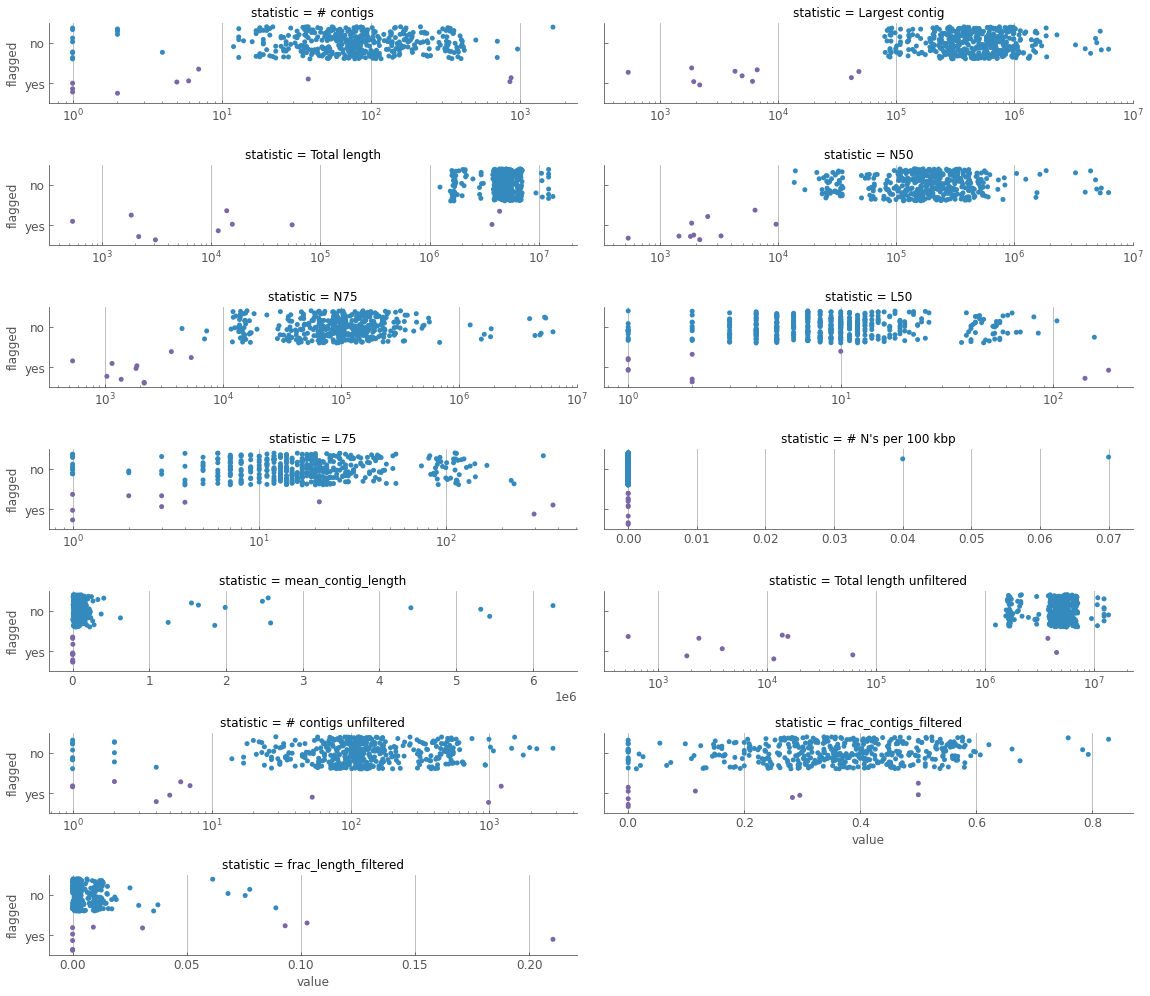

In [22]:
fg = sns.catplot(
    data=df_skinny.reset_index(),
    x='value',
    y='flagged',
    kind='strip',
    col='statistic',
    aspect=4,
    sharex=False,
    height=2,
    col_wrap=2,
    jitter=.4,
)

for col, ax in fg.axes_dict.items():
    if col in log_cols:
        ax.set_xscale('log')

## Write output

In [23]:
results2.to_csv(outfiles['main'])

In [24]:
by_bp.to_csv(outfiles['by_bp'])